In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 438 (delta 121), reused 57 (delta 54), pack-reused 269
Receiving objects: 100% (438/438), 118.31 KiB | 2.37 MiB/s, done.
Resolving deltas: 100% (223/223), done.
***********************************************************************
We will now install RAPIDS via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.2/955.2 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.5 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039284 sha256=851cb127e4627fe2f3bacd099022e5fea699d8f3b8b6f9d3f3c9d0a07a4929d3
  Stored in di

In [ ]:
import pickle
import json
import re
import nltk
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from bertopic import BERTopic
from tqdm import tqdm
from cuml.cluster import HDBSCAN
from cuml.manifold import UMAP
import torch
import os

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def create_datframe(directory = "/kaggle/input/gazatweetsunzipped/data/Twitter-Izrael-Hamas-Dataset-all-lang/Twitter-Izrael-Hamas-Dataset-all-lang/"):
    df_ac=pd.DataFrame()
    print("Consolidation of the files into one dataframe...")
    for fil in tqdm(os.listdir(directory)):
        flen=len(os.listdir(directory))
        file=fil
        filename=str(str(directory)+(os.fsdecode(fil)))
        try:
            df_act = pd.read_json(filename,lines=True)
            df_ac=df_ac.append(df_act)
        except:
            continue
        break
    return df_ac

def preprocess(data, text_col, join_to_text=True):
    data[text_col] = data.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
#     data[text_col] = data.apply(lambda row: re.sub(r'#', '', row.text))
    data[text_col] = data.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
    data[text_col] = data.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.text).split()), 1)

#     tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    data[text_col] = data[text_col].apply(nltk.tokenize.word_tokenize)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    data[text_col] = data[text_col].apply(lambda row: [word for word in row if word not in stop_words])

    # Stemming
    stemmer = nltk.stem.PorterStemmer()
    def stem_words(words):
        return [stemmer.stem(word) for word in words]
    data['stemmed_text'] =  data[text_col].apply(stem_words)

    if join_to_text:
        data[text_col] = data[text_col].apply(lambda row: ' '.join(row))
        data['stemmed_text'] = data['stemmed_text'].apply(
            lambda row: ' '.join(row)
        )

    return data
path = "/content/drive/MyDrive/en_tweets.csv"
data = pd.read_csv(path, sep=';', names=['text', 'timestamp'], header=None)
data = preprocess(data, "text")
timestamps = data.timestamp.to_list()
tweets = data.text.to_list()

In [ ]:
umap_model = UMAP(n_components=5, n_neighbors=15, min_dist=0.0)
hdbscan_model = HDBSCAN(min_samples=10, gen_min_span_tree=True, prediction_data=True)

nr_topics = 500

topic_model = BERTopic(
    hdbscan_model=hdbscan_model, umap_model=umap_model, verbose=True, nr_topics=nr_topics,
    calculate_probabilities=False
  )

# # tweets = tweets.text.to_list()
topics, probabs = topic_model.fit_transform(tweets)

2024-01-14 13:34:57,615 - BERTopic - Embedding - Transforming documents to embeddings.


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/10211 [00:00<?, ?it/s]

2024-01-14 13:36:52,624 - BERTopic - Embedding - Completed ✓
2024-01-14 13:36:52,625 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-14 13:40:16,078 - BERTopic - Dimensionality - Completed ✓
2024-01-14 13:40:16,098 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-14 13:40:39,201 - BERTopic - Cluster - Completed ✓
2024-01-14 13:40:39,203 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-14 13:40:51,863 - BERTopic - Representation - Completed ✓
2024-01-14 13:40:51,874 - BERTopic - Topic reduction - Reducing number of topics
2024-01-14 13:41:02,223 - BERTopic - Topic reduction - Reduced number of topics from 6348 to 500


\# of topics - Auto: 4965 topics

Cluster timestamps

Maybe reduce the amount of topics

In [ ]:
np.unique(timestamps).shape

(47438,)

In [ ]:
from datetime import datetime

def process_datetime(date_str):
    dt = date_str.split(' ')
    t = dt[-1].split('+')
    hour = datetime.strptime(t[0], '%H:%M:%S').hour
    return dt[0] + ' ' + str(hour) + ':00:00+00:00'

    # time_parse = lambda x: datetime.strptime(x, '')


processed_timestamps = list(map(process_datetime, timestamps))


In [ ]:
clusters = topic_model.visualize_topics()
barchart = topic_model.visualize_barchart()
topics_over_time = topic_model.topics_over_time(tweets, processed_timestamps, topics)
topics_overt = topic_model.visualize_topics_over_time(topics_over_time, 10)

70it [01:00,  1.16it/s]


In [ ]:
clusters

In [ ]:
barchart

In [ ]:
topics_overt

In [ ]:
# !mkdir data
# directory = "data/"
directory=''
clusters.write_html(directory+"clusters.html")
barchart.write_html(directory+"barchart.html")
topics_overt.write_html(directory+"topics_over_time.html")

In [ ]:
topic_model.get_topic_info()

Topic   Count                                     Name  \
0       -1  109454       -1_palestine_israel_people_support   
1        0   38827             0_footage_videos_hamas_video   
2        1   33472            1_stand_retweet_sorry_hostile   
3        2    7667         2_children_kidnapped_child_cover   
4        3    5184        3_injuries_cost_documented_deaths   
..     ...     ...                                      ...   
495    494      10  494_landmass_buffeted_himalayas_margins   
496    495       9     495_schumer_chuck_beijing_criticized   
497    496       7                496_bue_checks_trail_cash   
498    497       6    497_electronic_invested_alarm_systems   
499    498       6            498_fashola_balde_auto_cooked   

                                        Representation  \
0    [palestine, israel, people, support, israelis,...   
1    [footage, videos, hamas, video, bombing, terro...   
2    [stand, retweet, sorry, hostile, hope, hypocri...   
3    [children, kidnapped, child, cover, cages, kep...   
4    [injuries, cost, documented, deaths, peed, cor...   
..                                                 ...   
495  [landmass, buffeted, himalayas, margins, plati...   
496  [schumer, chuck, beijing, criticized, senate, ...   
497  [bue, checks, trail, cash, interest, obviously...   
498  [electronic, invested, alarm, systems, billion...   
499  [fashola, balde, auto, cooked, nysc, shey, cod...   

                                   Representative_Docs  
0    [bad day see stop war please israel palestine ...  
1    [rt israeli airstrikes completely destroyed ma...  
2    [rt think every time someone gets angry gaza r...  
3    [rt viral video claiming show israeli children...  
4    [rt human cost israeli palestinian conflict de...  
..                                                 ...  
495  [rt shows thin israel margins error india mass...  
496  [rt breaking us senate majority leader chuck s...  
497  [rt bue checks twitter seeking cash interest i...  
498  [rt alarm system border work electronic system...  
499  [rt mayor cooked another game get code group b...  

[500 rows x 5 columns]

In [ ]:
tweet_m = []
topic_vals = [-1,0,1,2,3]
t = np.array(topics)
for i in topic_vals:
  tmp = np.array(tweets)[t == i]
  tweet_m.append(tmp)
tweet_m = np.array(tweet_m)

In [ ]:
tweet_m.shape

(5,)

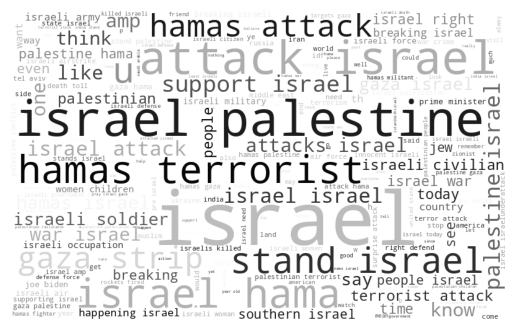

In [ ]:
import matplotlib.pyplot as plt

wc = WordCloud(background_color='white', colormap = 'binary',
     stopwords = ['rt'], width = 800, height = 500).generate('. '.join(tweet_m[0]))
plt.axis("off")
plt.imshow(wc)

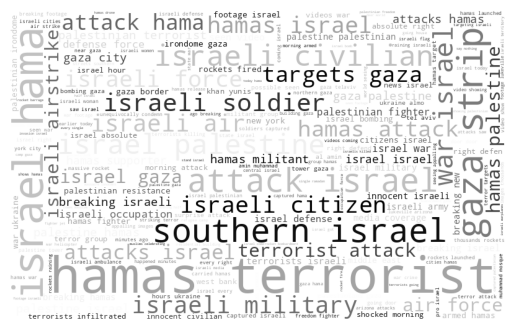

In [ ]:
wc = WordCloud(background_color='white', colormap = 'binary',
     stopwords = ['rt'], width = 800, height = 500).generate('. '.join(tweet_m[1]))
plt.axis("off")
plt.imshow(wc)

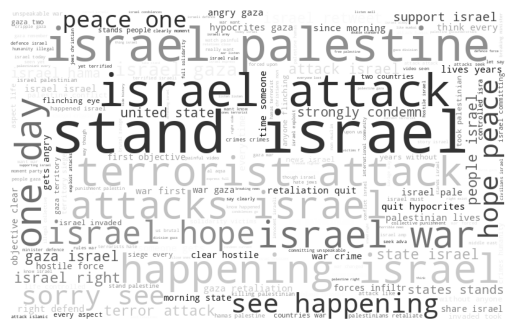

In [ ]:
wc = WordCloud(background_color='white', colormap = 'binary',
     stopwords = ['rt'], width = 800, height = 500).generate('. '.join(tweet_m[2]))
plt.axis("off")
plt.imshow(wc)

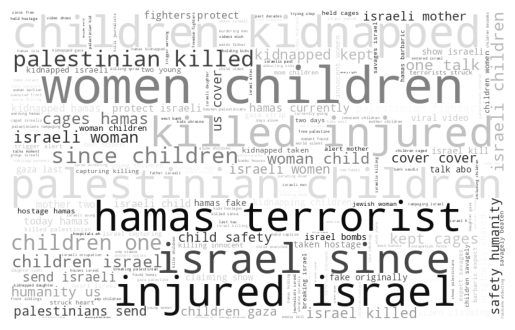

In [ ]:
wc = WordCloud(background_color='white', colormap = 'binary',
     stopwords = ['rt'], width = 800, height = 500).generate('. '.join(tweet_m[3]))
plt.axis("off")
plt.imshow(wc)

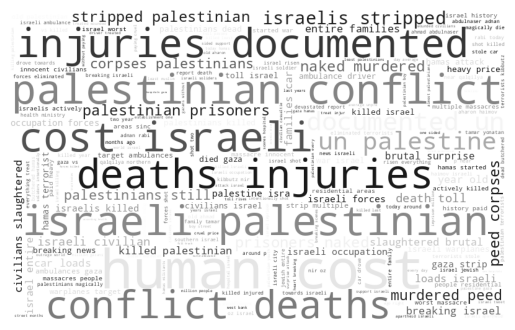

In [ ]:
wc = WordCloud(background_color='white', colormap = 'binary',
     stopwords = ['rt'], width = 800, height = 500).generate('. '.join(tweet_m[-1]))
plt.axis("off")
plt.imshow(wc)

In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
class TweetDataset(Dataset):
    def __init__(self, tweets, tokenizer):
        self.tweets = tweets
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer)
        self.len = len(tweets)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        res = res = self.tokenizer(
                self.tweets[index],
                return_tensors="pt",
                padding='max_length',
                truncation=True,
                max_length=128
            )
        res = {k:v[0] for k,v in res.items()}
        return res


In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

ds = TweetDataset(tweet_m[0], MODEL)
dl = DataLoader(ds, batch_size=64, shuffle=False)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
scores = []
device = 'cuda'
model = model.to(device)

def run_sa(dl):
    scores = []
    for batch in dl:
        x = {k:v.to(device) for k, v in batch.items()}
        output = model(**x)
        s = output[0][0].detach().cpu().numpy()
        s = softmax(s)
        scores.append(s)

    return np.sum(scores, axis=0)

In [ ]:
scores = []

for tweets_i in tweet_m:
    ds = TweetDataset(tweets_i, MODEL)
    dl = DataLoader(ds, batch_size=64, shuffle=False)
    res = run_sa(dl)
    scores.append(res)


In [ ]:
df = pd.DataFrame()
for res in scores:
    res = res / res.sum()
    df = df.append([res])
df

0         1         2
0  0.536868  0.397606  0.065525
0  0.625492  0.341770  0.032739
0  0.558611  0.377650  0.063739
0  0.771386  0.213649  0.014965
0  0.783669  0.206677  0.009654